# 动态折线图


### 1. 初始设置

首先，导入所需的库，并设置中文字体等。

In [1]:
# 导入所需的库
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 
import matplotlib.animation as animation
import datetime
from IPython.display import HTML

# 正常显示中文标签
mpl.rcParams['font.sans-serif'] = ['SimHei']

# 自动适应布局
mpl.rcParams.update({'figure.autolayout': True})

# 正常显示负号
mpl.rcParams['axes.unicode_minus'] = False

# 让网格线显示在下方
mpl.rc('axes', axisbelow=True)

# 禁用科学计数法
pd.set_option('display.float_format', lambda x: '%.2f' % x) 

# 定义颜色，主色：蓝色，辅助色：灰色，互补色：橙色
c = {'蓝色':'#00589F', '深蓝色':'#003867', '浅蓝色':'#5D9BCF',
     '灰色':'#999999', '深灰色':'#666666', '浅灰色':'#CCCCCC',
     '橙色':'#F68F00', '深橙色':'#A05D00', '浅橙色':'#FBC171'}

# 防止动态图显示不完整
plt.rcParams['animation.embed_limit'] = 1e100

### 2. 定义数据

In [2]:
# # 当需要更新数据时，去掉注释后运行一次
# import akshare as ak

# # 从 akshare 获取历史数据，速度比较慢
# df_all_history = ak.covid_19_history()

# # 保存到 Excel 文件中，以便下次快速读取数据
# df_all_history.to_excel('./data/covid_19_history_20200711.xlsx')

In [3]:
# 定义想要展示的国家
countries = ['中国', '美国']

# 从 Excel 文件中读取数据
df_all = pd.read_excel('./data/covid_19_history_20200711.xlsx', index_col=0).fillna('')

# 将字符串格式的日期转换为日期格式
df_all['date'] = pd.to_datetime(df_all['date'])

# 将时间格式转为字符串格式的日期，以 YYYY-mm-dd 的形式保存到另外一列
df_all['dates'] = df_all['date'].apply(lambda x:x.strftime('%Y-%m-%d'))

# 添加现存确诊列
df_all['current'] = df_all['confirmed'] - df_all['cured'] - df_all['dead']

# 排除省份的数据，只保留国家的数据，设置日期为索引
dfc = df_all.query("province==''").set_index('date')

# 对应每个国家的序号
n_list = [i for i in range(len(countries))]

# 以字典的方式存放每个国家的数据
dic = {}
for country_i in countries:
    dfi = dfc.query("country==@country_i")
    dfi = dfi.sort_index(ascending=True)
    dic[country_i] = dfi

# 计算最大的确诊人数
y_max = 0
for country_i in countries:
    y_max_i = dic[country_i]['confirmed'].max()
    y_max = max(y_max, y_max_i)

# 合并两个国家的确诊人数
df1 = pd.concat([dic[countries[0]].confirmed, dic[countries[1]].confirmed], axis=1)
df1.columns = [countries[0], countries[1]]
df1 = df1.fillna(0)

# 总天数
length = df1.shape[0] + 1

### 3. 开始画图

用「**面向对象**」的方法画图。

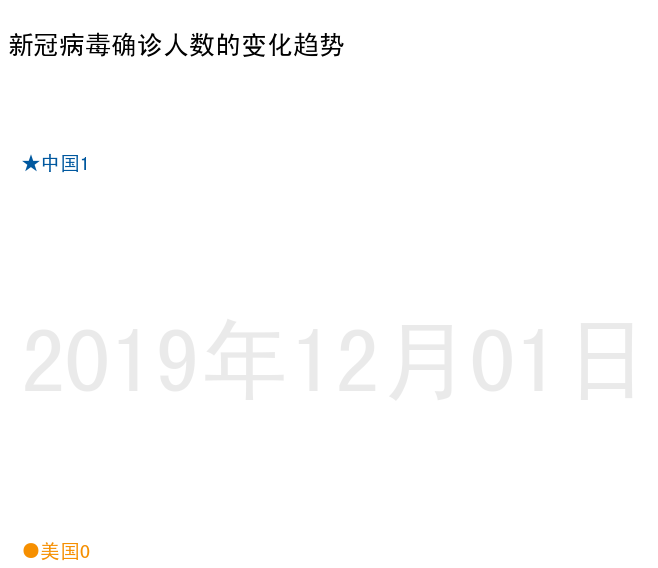

In [4]:
# 使用「面向对象」的方法画图，定义图片的大小
fig, ax = plt.subplots(figsize=(10, 8))

# 设置背景颜色
fig.set_facecolor('w')
ax.set_facecolor('w')

# 隐藏边框
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

# 隐藏刻度线
ax.tick_params(axis='x', which='major', length=0)
ax.tick_params(axis='y', which='major', length=0)

# 设置坐标标签字体大小和颜色
ax.tick_params(labelsize=16, colors=c['深灰色'])

# 定义动画函数
def animate(num): 
    # 先清空画面
    ax.clear()
    
    # 动态显示新的数据
    df_temp = df1.iloc[0:num, :]
    idx = df_temp.index

    # 绘制第一个国家的折线图
    ax.plot(idx, df_temp[countries[0]], color=c['蓝色'], linewidth=3, zorder=2)
    string = '★'+countries[0]+str(df_temp[countries[0]][-1])
    ax.text(idx[-1], df_temp[countries[0]][-1], string, size=20, ha='left', va='center', color=c['蓝色'])
    
    # 绘制第二个国家的折线图
    ax.plot(idx, df_temp[countries[1]], color=c['橙色'], linewidth=3, zorder=2)
    string = '●'+countries[1]+str(int(df_temp[countries[1]][-1]))
    ax.text(idx[-1], df_temp[countries[1]][-1], string, size=20, ha='left', va='bottom', color=c['橙色'])

    # 设置标题
    ax.set_title('\n新冠病毒确诊人数的变化趋势\n', loc='left', fontsize=26)
    
    # 图片背景显示日期的动态变化
    ymean = (ax.get_ylim()[0] + ax.get_ylim()[1]) / 2
    string = (df1.index[0]+datetime.timedelta(days=int(num-1))).strftime('%Y年%m月%d日')
    ax.text(df1.index[0], ymean, string, ha='left', va='center', fontsize=90, color=c['灰色'], zorder=-1, alpha=0.2)
    
    # 设置 X 轴坐标范围
    ax.set_xlim(df1.index[0]+datetime.timedelta(days=-5), df1.index[-1]+datetime.timedelta(days=5))
    # ax.set_xticks(ticks=[df1.index[0]] + [df1.index[int(length/2)]] + [df1.index[-1]])
    ax.set_xticklabels([])
    
    # 设置 Y 轴坐标范围
    ax.set_ylim(0, df1.iloc[0:num,:].values.max()*1.2)
    ax.set_yticklabels([])
    
# 绘制动画
animator = animation.FuncAnimation(fig, animate, frames=np.arange(1, length, 1), interval=100)

# 在 Jupyter Notebook 中显示动画
# HTML(animator.to_jshtml())

# 保存为 mp4 的文件格式
animator.save('动态折线图.mp4')